In [6]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import json
from analyze_utilities import *
from dataset_utilities import create_cifar10_dataloaders
import pandas as pd
import copy

%run ./result_summary.ipynb

In [7]:
# Define plot defaults
mpl.rcParams['figure.figsize'] = (14.0, 7.0)
mpl.rcParams['font.family'] = "Times New Roman"
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 16

# NML Vs. ERM Performence
NML is as training is as following:
1. Train base model with all trainset
2. Freeze first layers (only enable updates of layer 5,6 in resnet20)
3. For each test sample:
    1. For each label:
        1. Add the test sample with the label to trainset
        2. Train for 10 epochs the model
        3. Keep probability of the test sample label which it was trained with
    2. Take all save probabilities and normalize them.
    3. Report the new probability assignmnet

NML:
              jinni       nml       erm
acc        0.987500  0.918400  0.918300
mean loss  0.027294  0.167210  0.194359
std loss   0.230810  0.313679  0.821636


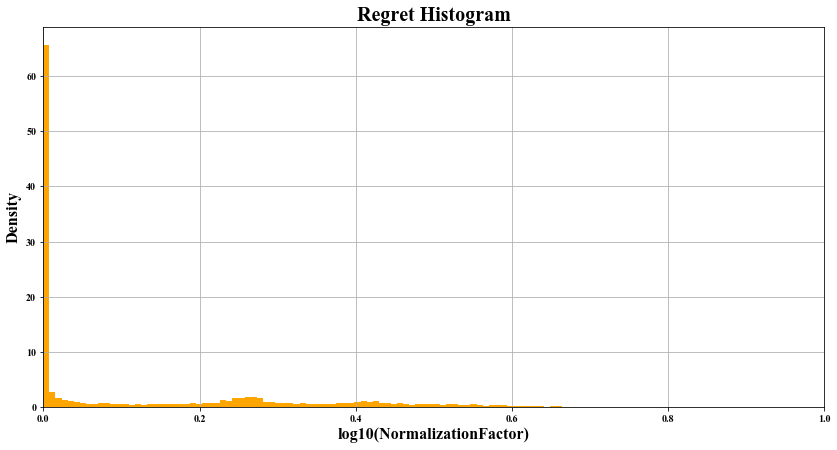

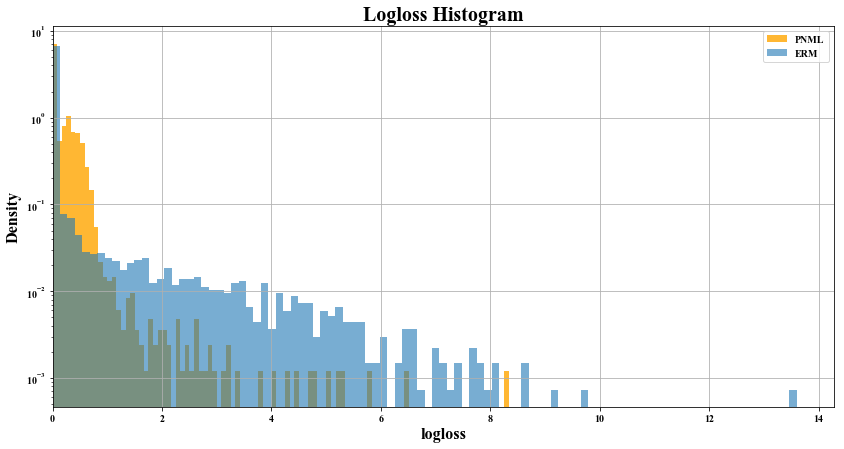

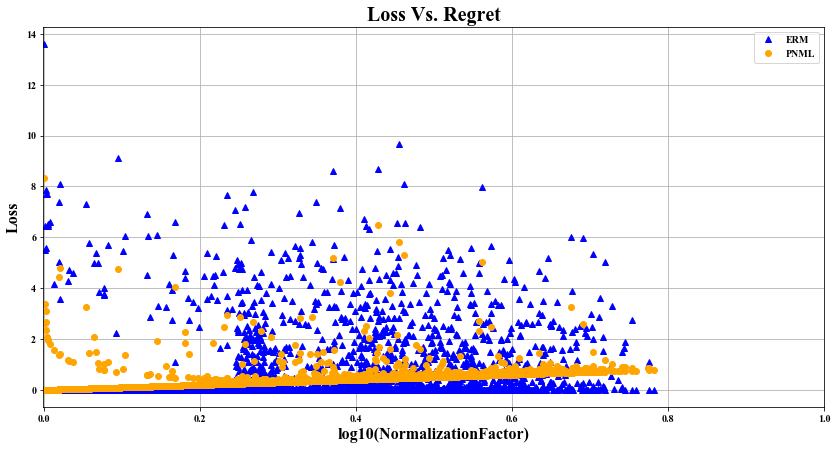

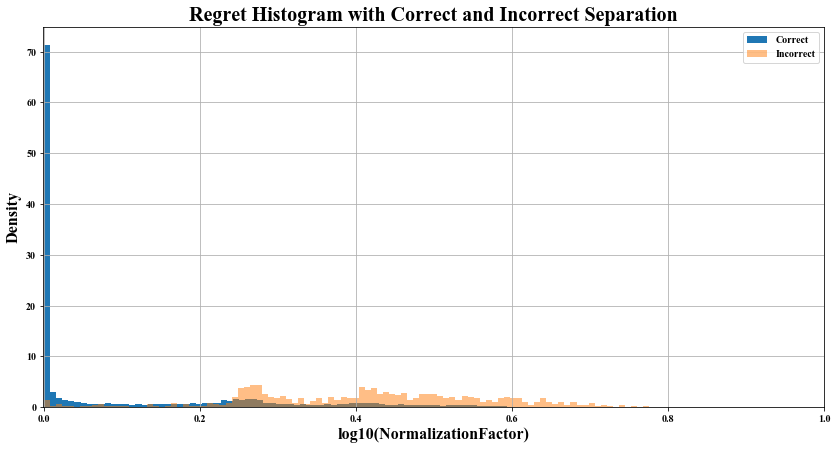

Correct = 9184, Incorrect = 816 


In [3]:
# Print acc and mean loss
result_df = load_results_to_df(files_nml_2_layers)
statistics_df = calc_statistic_from_df(result_df)
print('NML:')
print(statistics_df)

# Regret histogram
bins = 100
plt.hist(result_df['log10_norm_factor'], density=True, label='PNML', bins=bins, color='orange')
plt.xlim([-0.0001,1])
plt.title('Regret Histogram')
plt.xlabel('log10(NormalizationFactor)')
plt.ylabel('Density')
plt.show()

# logloss histogram
bins = 100
plt.hist(result_df['nml_loss'], bins=bins, alpha=0.8, label='PNML', density=True, color='orange')
plt.hist(result_df['erm_loss'], bins=bins, alpha=0.6, label='ERM', density=True)
plt.title('Logloss Histogram')
plt.xlabel('logloss')
plt.ylabel('Density')
plt.yscale('log')
plt.xlim(left=0)
plt.legend()
plt.show()

# Loss vs. NML nomralization factor
plt.plot(result_df['log10_norm_factor'], result_df['erm_loss'], 
         linestyle='None', color='blue', marker='^', label='ERM')
plt.plot(result_df['log10_norm_factor'], result_df['nml_loss'], 
         linestyle='None', color='orange', marker='o', label='PNML')
plt.title('Loss Vs. Regret')
plt.xlabel('log10(NormalizationFactor)')
plt.ylabel('Loss')
plt.xlim([-0.001,1])
plt.legend()
plt.show()

# Plot histogram of correct vs incorrect
bins= 100
correct_norm_factor = result_df['log10_norm_factor'][result_df['nml_is_correct'] == True]
incorrect_norm_factor = result_df['log10_norm_factor'][result_df['nml_is_correct'] == False]
plt.hist(correct_norm_factor, alpha=1, bins=bins, density=True, label='Correct')
plt.hist(incorrect_norm_factor, alpha=0.5, bins=bins, density=True, label='Incorrect')
plt.title('Regret Histogram with Correct and Incorrect Separation')
plt.xlabel('log10(NormalizationFactor)')
plt.ylabel('Density')
plt.xlim([-0.001,1])
plt.legend()
plt.show()
print('Correct = %d, Incorrect = %d '% (correct_norm_factor.shape[0], incorrect_norm_factor.shape[0]))

# Compose estimator based on the regret

In [4]:
#  Construct best loss based on normalization factor
threshold_list = np.linspace(np.finfo(float).eps,1,99)
acc_list = []
cdf_list = []
nml_thresh_loss_list = []
for threshold in threshold_list:
    
    df = result_df[result_df['log10_norm_factor']<threshold]
    
    # loss
    nml_thresh_loss_list.append(df['nml_loss'].mean())
        
    # Acc
    acc_single =  np.sum(df['nml_is_correct'] == True) / (df.shape[0] + np.finfo(float).eps)
    acc_list.append(acc_single)
    
    cdf_single = df.shape[0] / result_df.shape[0]
    cdf_list.append(cdf_single)  

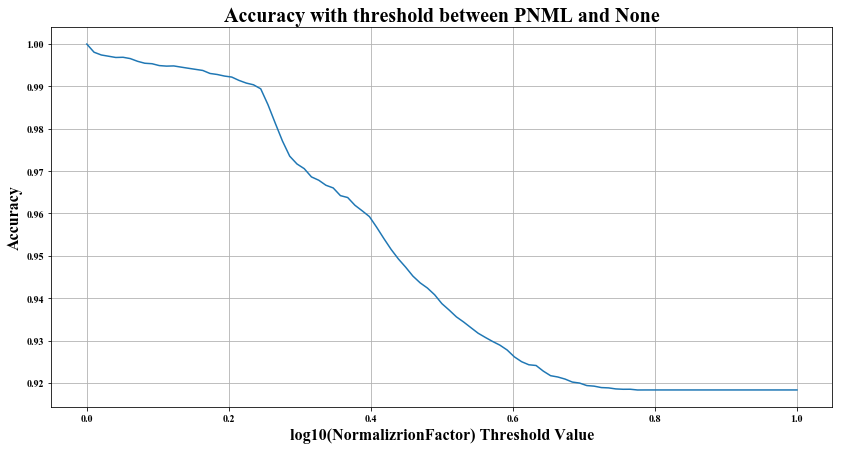

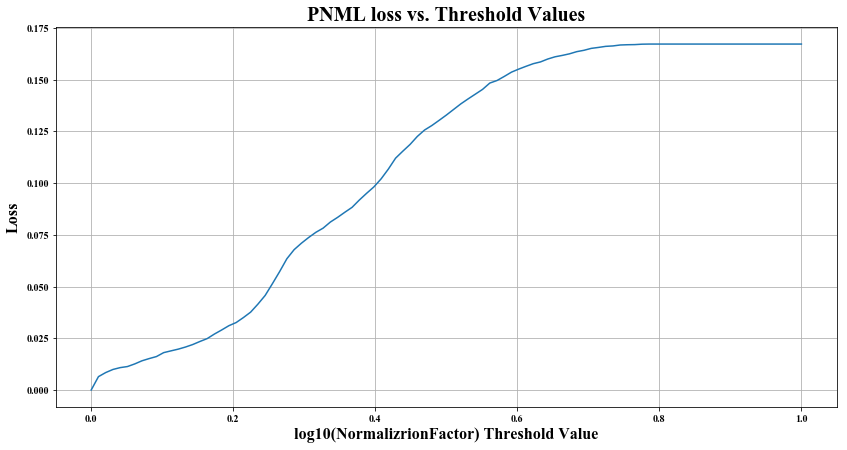

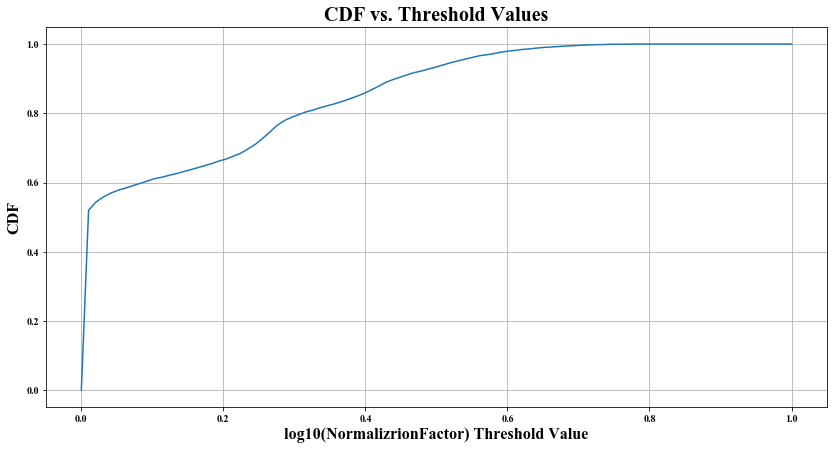

In [5]:
# Plot Acc
plt.plot(threshold_list, acc_list, label='Thresholded')
plt.xlabel('log10(NormalizrionFactor) Threshold Value')
plt.ylabel('Accuracy')
plt.title('Accuracy with threshold between PNML and None')
plt.show()

# Plot PNML loss
plt.plot(threshold_list, nml_thresh_loss_list, label='NML loss')
plt.xlabel('log10(NormalizrionFactor) Threshold Value')
plt.ylabel('Loss')
plt.title('PNML loss vs. Threshold Values')
plt.show()

# Plot CDF
plt.plot(threshold_list, cdf_list, label='Threshold Acc CDF')
plt.xlabel('log10(NormalizrionFactor) Threshold Value')
plt.ylabel('CDF')
plt.title('CDF vs. Threshold Values')
plt.show()

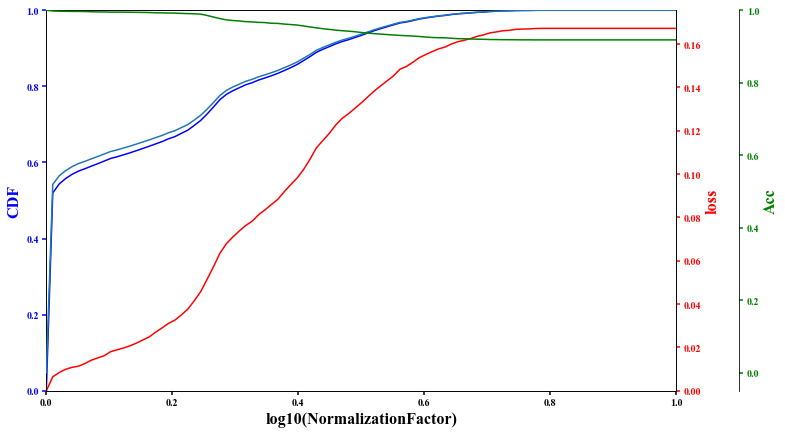

In [6]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

fig, host = plt.subplots()
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

plt.plot(threshold_list, cdf_list, label='Threshold Acc CDF')
par2.spines["right"].set_position(("axes", 1.1))
make_patch_spines_invisible(par2)
par2.spines["right"].set_visible(True)

p1, = host.plot(threshold_list, cdf_list, "b-", label="CDF")
p2, = par1.plot(threshold_list, nml_thresh_loss_list, "r-", label="loss")
p3, = par2.plot(threshold_list, acc_list, "g-", label="Acc")

host.set_xlim([0, 1])
host.set_ylim([0,1])
par1.set_ylim(bottom=0)
par2.set_ylim(top=1.0)

host.set_xlabel("log10(NormalizationFactor)")
host.set_ylabel("CDF")
par1.set_ylabel("loss")
par2.set_ylabel("Acc")

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
host.tick_params(axis='x', **tkw)
lines = [p1, p2, p3]
# host.legend(lines, [l.get_label() for l in lines])
host.grid(False)
par1.grid(False)
par2.grid(False)
plt.show()

# Top K accuracy

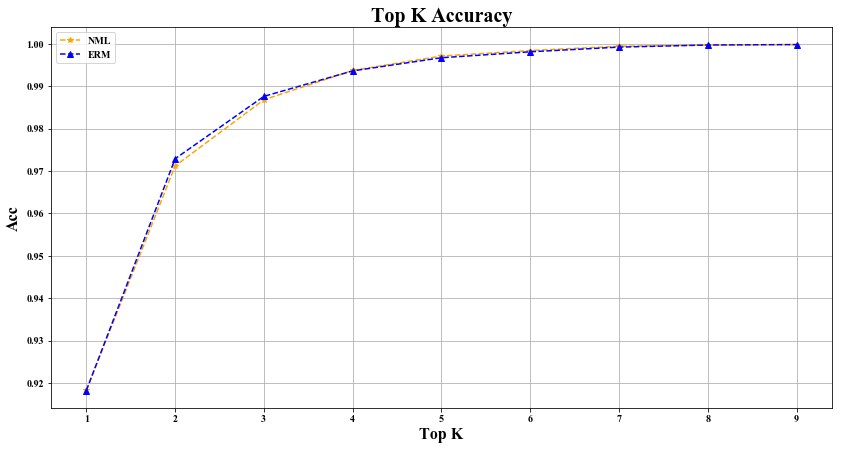

In [7]:
results_dict = load_dict_from_file_list(files_nml_2_layers)

acc_top_k_nml_list, acc_top_k_erm_list  = [], []
for k in range(1,10):
    acc_top_k_nml, acc_top_k_erm = calculate_top_k_acc(results_dict,k)
    acc_top_k_nml_list.append(acc_top_k_nml)
    acc_top_k_erm_list.append(acc_top_k_erm)
    

plt.plot(list(range(1,10)),acc_top_k_nml_list, '--*' , label='NML', color='orange')
plt.plot(list(range(1,10)),acc_top_k_erm_list, '--^' , label='ERM', color='blue')
plt.xlabel('Top K')
plt.ylabel('Acc')
plt.title('Top K Accuracy')
plt.legend()
plt.show()

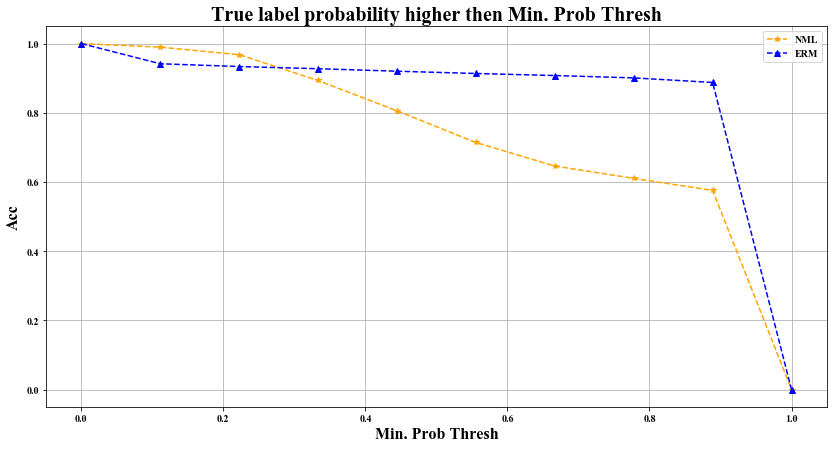

In [8]:
results_dict = load_dict_from_file_list(files_nml_2_layers)
acc_top_k_nml_list, acc_top_k_erm_list  = [], []
prob_thresh_list = np.linspace(0,1,10)
for prob_thresh in prob_thresh_list:
    acc_top_k_nml, acc_top_k_erm = calculate_top_k_acc(results_dict,10, prob_thresh)
    acc_top_k_nml_list.append(acc_top_k_nml)
    acc_top_k_erm_list.append(acc_top_k_erm)
    

plt.plot(prob_thresh_list,acc_top_k_nml_list, '--*' , label='NML', color='orange')
plt.plot(prob_thresh_list,acc_top_k_erm_list, '--^' , label='ERM', color='blue')
plt.xlabel('Min. Prob Thresh')
plt.ylabel('Acc')
plt.title('True label probability higher then Min. Prob Thresh')
plt.legend()
plt.show()

# Out  of Disterbution

Cifar10: loaded 9991 keys
Noise: loaded 100 keys
SVHN: loaded 100 keys
log10(NormalizationFactor): [cifar10 svhn noise]=[0.13992456749145493, 0.47305804001135926, 0.6994421087314094]


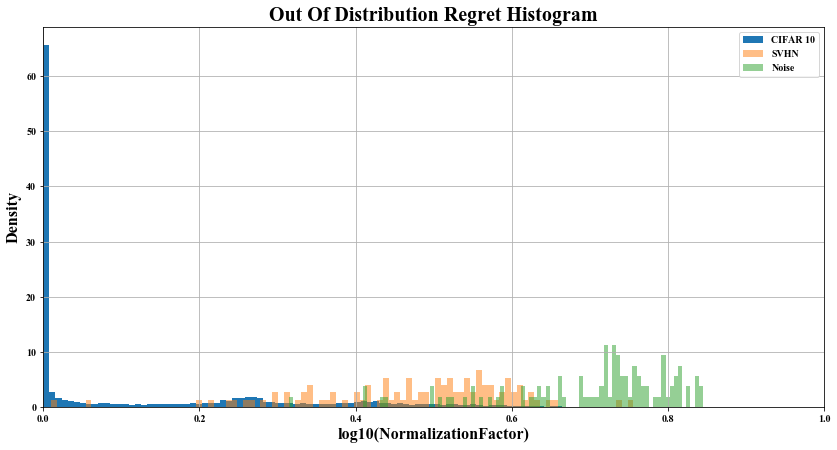

In [9]:
# Load svhn and noise
results_dict_cifar10 = load_dict_from_file_list(files_nml_2_layers)
print('Cifar10: loaded %d keys' % len(results_dict_cifar10))
results_dict_noise = load_dict_from_file_list(files_noise)
print('Noise: loaded %d keys' % len(results_dict_noise))
results_dict_svhn = load_dict_from_file_list(files_svhn)
print('SVHN: loaded %d keys' % len(results_dict_svhn))


# Extract and plot normalization factor
_, normalization_factor_cifar10_list, _, _, _  = get_NML_log_loss_from_dict(results_dict_cifar10)
_, normalization_factor_svhn_list, _, _, _  = get_NML_log_loss_from_dict(results_dict_svhn)
_, normalization_factor_noise_list, _, _, _ = get_NML_log_loss_from_dict(results_dict_noise)

log10_norm_factor_cifar10 =  np.log10(normalization_factor_cifar10_list)
log10_norm_factor_svhn = np.log10(normalization_factor_svhn_list)
log10_norm_factor_noise = np.log10(normalization_factor_noise_list).tolist()

# Print the mean
print('log10(NormalizationFactor): [cifar10 svhn noise]={}'.format([np.mean(log10_norm_factor_cifar10),
                                                                    np.mean(log10_norm_factor_svhn),
                                                                    np.mean(log10_norm_factor_noise)]))
#Plot
bins = 100
plt.hist(log10_norm_factor_cifar10, alpha=1, density=True, label='CIFAR 10', bins=bins)
plt.hist(log10_norm_factor_svhn, alpha=0.5, density=True, label='SVHN', bins=bins)
plt.hist(log10_norm_factor_noise, alpha=0.5, density=True, label='Noise', bins=bins)
plt.xlim([0,1])
plt.ylabel('Density')
plt.xlabel('log10(NormalizationFactor)')
plt.title('Out Of Distribution Regret Histogram')
plt.legend()
plt.show()

# Compare Training layers: 7, 5, 2
As opposite to the previous section, here all the model was trained and not only the 2 last layers

In [10]:
# Load results files into df
result_2_layers_df = load_results_to_df(files_nml_2_layers)
result_5_layers_df = load_results_to_df(files_nml_5_layers)
result_7_layers_df = load_results_to_df(files_nml_7_layers)

# Create combined dataframe
col_to_keep = ['nml_loss', 'nml_is_correct']

result_0_layers_df = result_2_layers_df[['erm_loss', 'erm_is_correct']]
result_0_layers_df.columns = ['nml_loss_0_layers', 'nml_is_correct_0_layers']
result_2_layers_df = result_2_layers_df[col_to_keep]
result_2_layers_df.columns = ['nml_loss_2_layers', 'nml_is_correct_2_layers']
result_5_layers_df = result_5_layers_df[col_to_keep]
result_5_layers_df.columns = ['nml_loss_5_layers', 'nml_is_correct_5_layers']
result_7_layers_df = result_7_layers_df[col_to_keep]
result_7_layers_df.columns = ['nml_loss_7_layers', 'nml_is_correct_7_layers']

combined_df = pd.concat([result_0_layers_df, result_2_layers_df, result_5_layers_df, result_7_layers_df], 
                        axis=1, join='inner')
combined_df.head()

,nml_loss_0_layers,nml_is_correct_0_layers,nml_loss_2_layers,nml_is_correct_2_layers,nml_loss_5_layers,nml_is_correct_5_layers,nml_loss_7_layers,nml_is_correct_7_layers
0,-9.643275e-17,True,2.151972e-07,True,1.208843e-03,True,1.239797e-04,True
1,-9.643275e-17,True,4.679210e-06,True,2.471130e-02,True,2.093676e-03,True
10,1.863794e-06,True,2.555111e-01,True,5.063146e-01,True,4.386285e-01,True
11,-9.643275e-17,True,2.682267e-11,True,2.107107e-09,True,1.339399e-09,True
12,3.176553e-01,False,4.814189e-01,True,6.014721e-01,False,5.401038e-01,False


Num of samples: 136


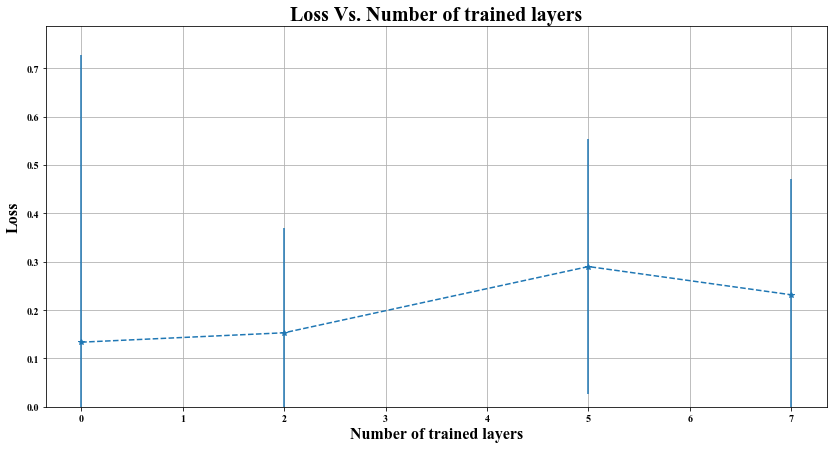

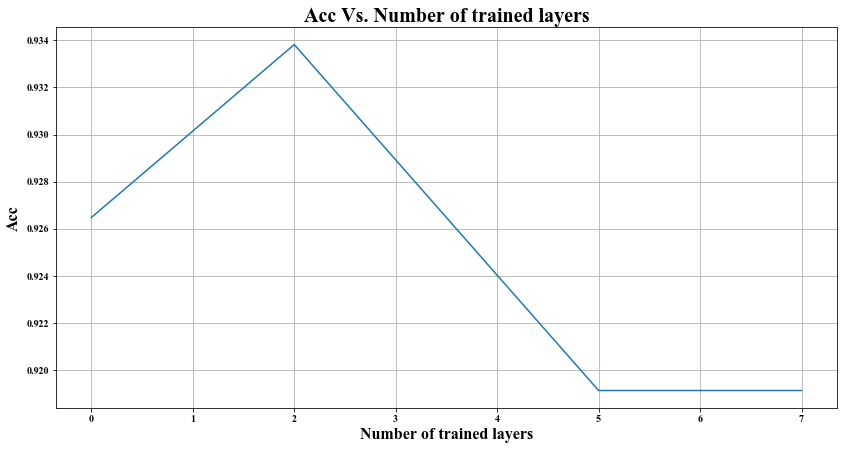

In [11]:
# Calculate statistic
mean_loss = np.mean([combined_df['nml_loss_0_layers'],
                     combined_df['nml_loss_2_layers'],
                     combined_df['nml_loss_5_layers'],
                     combined_df['nml_loss_7_layers']], axis=1)
std_loss = np.std([combined_df['nml_loss_0_layers'],
                     combined_df['nml_loss_2_layers'],
                     combined_df['nml_loss_5_layers'],
                     combined_df['nml_loss_7_layers']], axis=1)

acc = [np.sum(combined_df['nml_is_correct_0_layers'] == True) / combined_df.shape[0],
       np.sum(combined_df['nml_is_correct_2_layers'] == True) / combined_df.shape[0],
       np.sum(combined_df['nml_is_correct_5_layers'] == True) / combined_df.shape[0],
       np.sum(combined_df['nml_is_correct_7_layers'] == True) / combined_df.shape[0]]
       

print('Num of samples: %d' % combined_df.shape[0] )
plt.errorbar([0, 2, 5, 7], mean_loss, yerr=std_loss, fmt='--*')
plt.ylim(bottom=0)
plt.title('Loss Vs. Number of trained layers')
plt.xlabel('Number of trained layers')
plt.ylabel('Loss')
plt.show()


plt.plot([0, 2, 5, 7], acc)
plt.title('Acc Vs. Number of trained layers')
plt.xlabel('Number of trained layers')
plt.ylabel('Acc')
plt.show()

# Random labels

In [12]:
# Count param diffrence between WideResnet and Resnet20
from wide_resnet import WideResNet
from resnet import resnet20
model = WideResNet()
wide_resnet_params = sum(p.numel() for p in model.parameters())
model = resnet20()
resnet20_params = sum(p.numel() for p in model.parameters())
print('[WideResnet Resnet20]=[{} {}]'.format(wide_resnet_params, resnet20_params))
print('Ratio {}]'.format(wide_resnet_params/resnet20_params))

[WideResnet Resnet20]=[369498 269722]
Ratio 1.3699216230044269]


In [12]:
# Extract the log normalization factor
mean_log_norm_factor_list = []
std_log_norm_factor_list = []

nml_loss_list = []
nml_acc_list = []
erm_loss_list = []
erm_acc_list = []

for idx, file_random in enumerate(files_random):
    print('Loading idx = ', idx)
    results_dict = load_dict_from_file_list(file_random)
    nml_loss, norm_factor_list, nml_acc, is_correct_nml, idx_in_dataset  = get_NML_log_loss_from_dict(results_dict, is_random_labels = True);
    erm_loss, erm_acc, is_correct_erm = get_ERM_log_loss_from_dict(results_dict, is_random_labels = True);
    mean_log_norm_factor_list.append(np.log10(norm_factor_list).mean())
    std_log_norm_factor_list.append(np.log10(norm_factor_list).std())
    erm_acc_list.append(erm_acc)
    nml_acc_list.append(nml_acc)
    erm_loss_list.append(np.mean(erm_loss))
    nml_loss_list.append(np.mean(nml_loss))
print('Finish')

Loading idx =  0
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Loading idx =  1
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Loading idx =  2
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Loading idx =  3
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Loading idx =  4
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Loading idx =  5
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded

Prob2beRandom=[0.0, 0.01, 0.03, 0.1, 0.3, 0.5, 0.6, 1.0]
log10(NormalizationFactor)=[0.527 0.566 0.619 0.751 0.825 0.882 0.866 0.707]


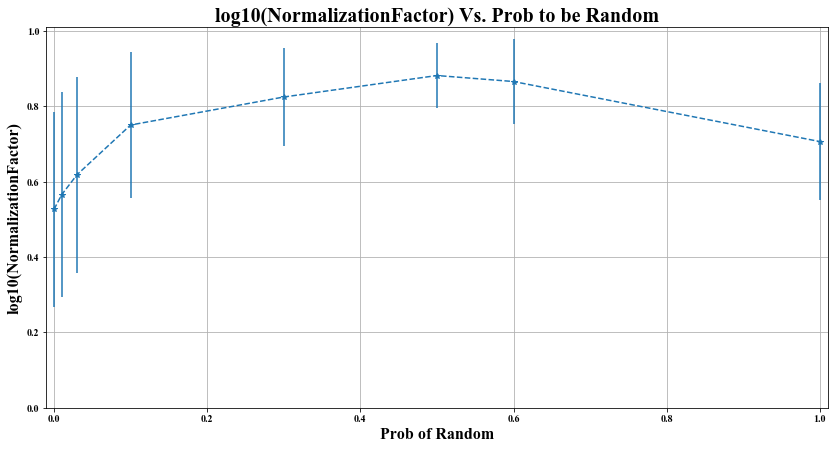

In [13]:
print('Prob2beRandom={}'.format(random_prob))
print('log10(NormalizationFactor)={}'.format( np.round(mean_log_norm_factor_list,3)))

# Plot 
plt.errorbar(random_prob,  mean_log_norm_factor_list, yerr=std_log_norm_factor_list, fmt='--*',  label='NML')
plt.ylabel('log10(NormalizationFactor)')
plt.xlabel('Prob of Random')
plt.title('log10(NormalizationFactor) Vs. Prob to be Random')
plt.ylim([0,1.01])
plt.xlim([-0.01,1.01])
plt.show()

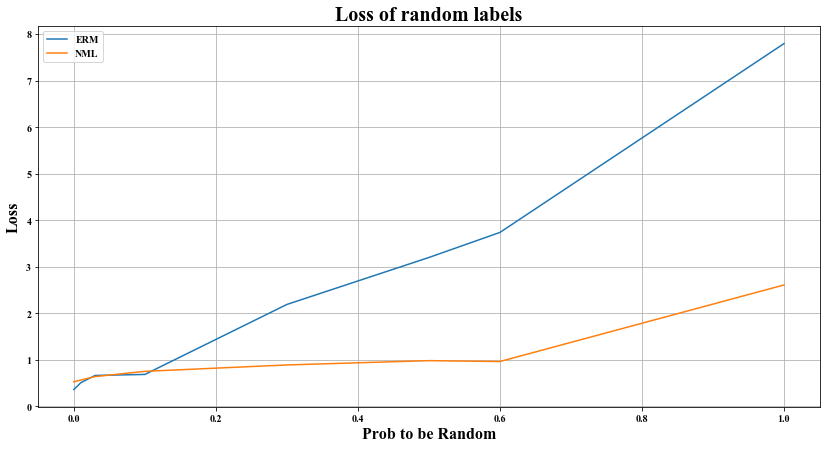

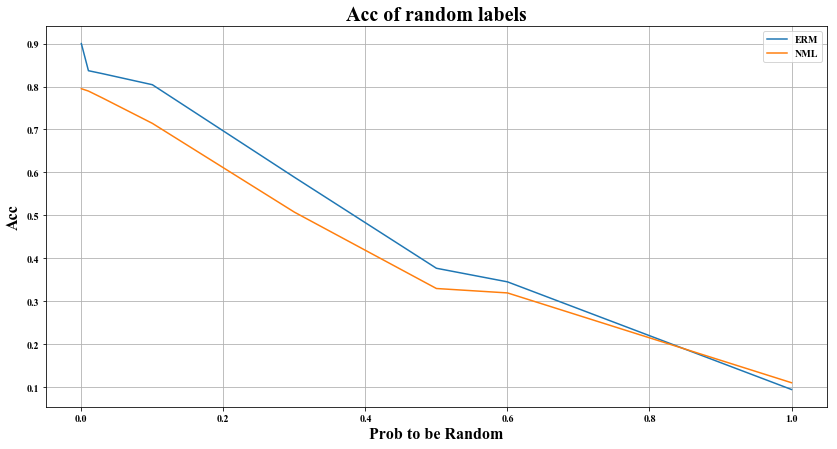

In [14]:
# Check noisy data
plt.plot(random_prob, erm_loss_list, label='ERM')
plt.plot(random_prob, nml_loss_list, label='NML')
plt.title('Loss of random labels')
plt.ylabel('Loss')
plt.xlabel('Prob to be Random')
plt.legend()
plt.show()

plt.plot(random_prob, erm_acc_list, label='ERM')
plt.plot(random_prob, nml_acc_list, label='NML')
plt.title('Acc of random labels')
plt.ylabel('Acc')
plt.xlabel('Prob to be Random')
plt.legend()
plt.show()

## Check outliers in the above graph

# Visualize False classified
Visaulaize the image of the false classified by the ERM and NML

In [15]:
result_df.head()

,nml_loss,erm_loss,jinni_loss,log10_norm_factor,nml_is_correct,erm_is_correct,jinni_is_correct
0,2.151972e-07,-9.643275e-17,-9.643275e-17,2.151972e-07,True,True,True
1,4.679210e-06,-9.643275e-17,-9.643275e-17,4.679210e-06,True,True,True
10,2.555111e-01,1.863794e-06,1.915566e-06,2.555092e-01,True,True,True
11,2.682267e-11,-9.643275e-17,-9.643275e-17,2.682277e-11,True,True,True
12,4.814189e-01,3.176553e-01,2.251216e-02,4.589067e-01,True,False,True


In [16]:
# Check when erm and nml are not agree
disagree = np.logical_not(np.logical_and(np.array(result_df['nml_is_correct']), np.array(np.array(result_df['erm_is_correct']))))
disagree_idxes = np.array(result_df.index.values)[disagree==True].astype(np.int).tolist()
print(disagree_idxes)

[12, 35, 52, 58, 59, 61, 112, 118, 128, 129, 147, 158, 160, 165, 169, 171, 178, 188, 192, 223, 224, 226, 232, 281, 284, 306, 312, 340, 342, 357, 368, 370, 378, 384, 411, 412, 418, 426, 433, 456, 459, 474, 477, 478, 483, 531, 549, 562, 598, 618, 631, 665, 671, 675, 680, 683, 710, 725, 727, 731, 734, 739, 770, 793, 796, 799, 810, 811, 836, 862, 866, 882, 888, 893, 900, 910, 923, 924, 925, 933, 943, 953, 956, 972, 993, 994, 1019, 1040, 1042, 1049, 1050, 1072, 1088, 1095, 1100, 1118, 1129, 1131, 1150, 1163, 1172, 1181, 2005, 2023, 2034, 2036, 2046, 2061, 2066, 2078, 2091, 2128, 2159, 2161, 2165, 2172, 2186, 2187, 2205, 2226, 2232, 2242, 2251, 2262, 2270, 2271, 2283, 2293, 2299, 2309, 2331, 2350, 2355, 2361, 2362, 2372, 2394, 2405, 7000, 7002, 7005, 7016, 7041, 7059, 7068, 7080, 7082, 7099, 7107, 7112, 7143, 7147, 7150, 7168, 7174, 7177, 7202, 7218, 7235, 7246, 7274, 7311, 7343, 7347, 7367, 7370, 7384, 7398, 7400, 7406, 7408, 7509, 7520, 7524, 7549, 7561, 7562, 7590, 7600, 7605, 7609, 7617,

Files already downloaded and verified
Files already downloaded and verified


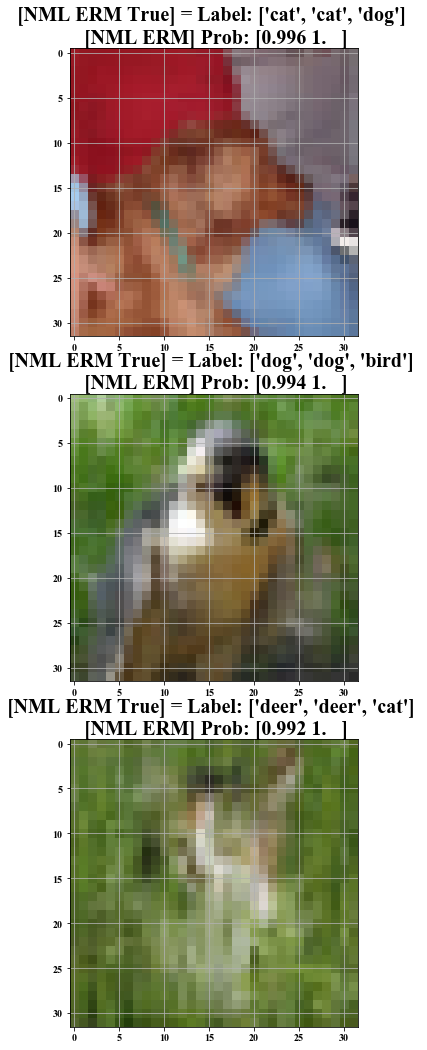

In [17]:
# Given a dict an idx, visualize ERM and NMl with prob of each. along with ground truth

# Inputs
results_dict =  load_dict_from_file_list(files_nml_2_layers)
dict_idxes = [158, 384, 456] #disagree_idxes # [245, 246]


# Initialzie dataset and plots
fig = plt.figure(figsize=(20, 6*len(dict_idxes)))
trainloader, testloader, classes =  create_cifar10_dataloaders('../data', 1, 1)

# Loop on dict  idxes
for iter_idx, dict_idx in enumerate(dict_idxes):
    prob_nml, true_label, predicted_label, prob_erm =  extract_probabilities_list(results_dict[str(dict_idx)])
    prob_nml, normalization_factor= execute_normalize_prob(prob_nml)

    # Extract class names
    class_predict_nml = classes[np.argmax(prob_nml)]
    class_predict_erm = classes[np.argmax(prob_erm)]
    class_predict_gt = classes[true_label]
    # Extract image
    data = testloader.dataset.test_data[dict_idx]

    # Plot the image
    ax = fig.add_subplot(len(dict_idxes),1,iter_idx + 1)
    ax.imshow(data)
    ax.set_title('[NML ERM True] = Label: {} \n [NML ERM] Prob: {}'
                 .format([class_predict_nml, class_predict_erm, class_predict_gt],
                         np.round([prob_nml[np.argmax(prob_nml)], prob_erm[np.argmax(prob_erm)]],3)))

plt.show()